In [1]:
%matplotlib inline

from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
import re
import time
import math
import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import collections
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import concurrent.futures
from tqdm.notebook import tqdm_notebook
from concurrent.futures import ThreadPoolExecutor
from typing import List, Tuple, Dict
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from collections import defaultdict
import seaborn as sns

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
def get_soup_from_url(url: str, headers: Dict[str, str], page_number: int) -> BeautifulSoup:
    """
    Fetch the HTML content from a given URL with the specified headers and page number.

    Parameters:
        url (str): The base URL.
        headers (dict): The HTTP headers to be used for the request.
        page_number (int): The page number to fetch.

    Returns:
        BeautifulSoup: The parsed HTML content.
    """
    try:
        response = requests.get(url.format(page_number), headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        return soup

    except requests.exceptions.RequestException as e:
        raise Exception("Error occurred while making the request:", e)

def find_number_of_jobs_and_pages(soup: BeautifulSoup) -> Tuple[int, int]:
    """
    Extract the number of jobs and calculate the number of pages from the given soup.

    Parameters:
        soup (BeautifulSoup): The parsed HTML content.

    Returns:
        Tuple[int, int]: Number of jobs and number of pages.
    """
    try:
        count_block = soup.find_all('span')
        tot_num_jobs = count_block[2].text
        array_tot_num_jobs = tot_num_jobs.split(' ')
        num_jobs = int(array_tot_num_jobs[-2].replace(',', ''))
        num_pages = num_jobs // 30

        return num_jobs, num_pages

    except (IndexError, ValueError, AttributeError) as e:
        raise Exception("Error occurred while finding the number of jobs:", e)

def fetch_and_process_page(url: str, headers: Dict[str, str], page_number: int) -> List[str]:
    """
    Fetch and process job titles from a given page number.

    Parameters:
        url (str): The base URL.
        headers (dict): The HTTP headers to be used for the request.
        page_number (int): The page number to fetch.

    Returns:
        List[str]: List of job titles for the current page.
    """
    soup = get_soup_from_url(url, headers, page_number)
    if soup:
        job_title_elements = soup.select(".job-title")
        return [process_job_title_element(element) for element in job_title_elements]

    return []

def get_job_titles(url: str, headers: Dict[str, str], num_pages: int) -> List[str]:
    """
    Fetch and process job titles from multiple search pages with concurrency.

    Parameters:
        url (str): The base URL.
        headers (dict): The HTTP headers to be used for the request.
        num_pages (int): The number of search result pages.

    Returns:
        List[str]: List of all job titles.
    """
    job_title_arr = []

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(fetch_and_process_page, url, headers, page) for page in range(1, num_pages + 1)]
        for future in tqdm_notebook(concurrent.futures.as_completed(futures), total=len(futures), desc="Fetching job titles", leave=True):
            job_title_arr.extend(future.result())

    return job_title_arr

def process_job_title_element(element: BeautifulSoup) -> str:
    """
    Process the job title element and apply substitutions.

    Parameters:
        element (BeautifulSoup): The job title element.

    Returns:
        str: Processed job title.
    """
    substitutions = {
        "job title -": "",
        "remote": "",
        "hybrid": "",
        "/": " ",
        "|": "",
        "(": "",
        ")": "",
        " - ": " ",
        "onsite": "",
        "w2": "",
        "permanent": "",
        "perm": "",
        "-": "",
        "required": "",
        "urgent": "",
        ":": "",
        "days": "",
        "day": "",
        "position": "",
    }

    ind_title = element.get_text().strip().lower()
    for old_str, new_str in substitutions.items():
        ind_title = ind_title.replace(old_str, new_str)
    ind_title = ind_title[:len(ind_title) // 2]
    return ind_title

def fetch_and_process_job_data(url: str, headers: Dict[str, str]) -> None:
    """
    Fetch and process job data, including job titles.

    Parameters:
        url (str): The base URL.
        headers (dict): The HTTP headers to be used for the request.
    """
    try:
        soup = get_soup_from_url(url, headers, "1")
        num_jobs, num_pages = find_number_of_jobs_and_pages(soup)
        if num_jobs is not None and num_pages is not None:
            print("Number of jobs:", num_jobs)
            print("Number of pages:", num_pages)

            # Add a delay between requests to avoid Too Many Requests error
            time.sleep(2)

            # job_title_arr = get_job_titles(url, headers, num_pages)
            job_title_arr = get_job_titles(url, headers, 5)
            print("Job Titles:", job_title_arr)
            return job_title_arr
        else:
            print("Unable to find the number of jobs and pages.")

    except requests.exceptions.RequestException as e:
        print("An error occurred while fetching data:", e)

## Webscrape with Beautiful Soup the Job Titles for All Pages

In [3]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}
url = "https://www.dice.com/jobs/q--manager%20-sales%20-customer%20-design*%20-test*%20-account%20-limit-30-l-94158-radius-30-startPage-{}-limit-30-jobs"



# Call the function to fetch and process job data
job_title_arr = fetch_and_process_job_data(url, headers)

Number of jobs: 10279
Number of pages: 342


Fetching job titles:   0%|          | 0/5 [00:00<?, ?it/s]

Job Titles: ['role with uber data engineer iii', 'ai ml architect', 'iteration manager ', ' role product manager ai ml', 'ux design researcher in san francisco, ca', 'sr software engineer', 'principal software engineer', 'desktop support', 'golang react developer ', 'digital analyst', 'sr user experience designer', 'it project manager', 'project manager', 'project engineer', 'technical product manager ', 'ux visual designer ii', 'executive non it', 'excellent job bsa  program manager_ san francisco 94103 ', 'content strategist', 'cybersecurity engineer 4     1    ', 'role with uber data engineer iii', 'ai ml architect', 'iteration manager ', ' role product manager ai ml', 'ux design researcher in san francisco, ca', 'sr software engineer', 'principal software engineer', 'desktop support', 'golang react developer ', 'digital analyst', 'sr user experience designer', 'it project manager', 'project manager', 'project engineer', 'technical product manager ', 'ux visual designer ii', 'execut

In [4]:
len(job_title_arr)

100

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from typing import List, Optional

def create_wordcloud_from_job_titles(job_title_arr: List[str]) -> str:
    """
    Create a WordCloud from a list of job titles.

    Parameters:
        job_title_arr (List[str]): List of job titles.

    Returns:
        str: Concatenated job titles as a single string.
    """
    if job_title_arr is not None:
        # Convert all elements in the 'job_title_arr' list to strings using list comprehension
        job_titles = [str(title) for title in job_title_arr]

        # Concatenate all the text elements in the array into a single string
        text_data = ', '.join(job_titles)

        # Create a WordCloud object with NLTK-based tokenization
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

        # Display the word cloud using matplotlib
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

        return text_data
    else:
        print("No job titles found.")
        return ""

## Plot Words on a Word Map

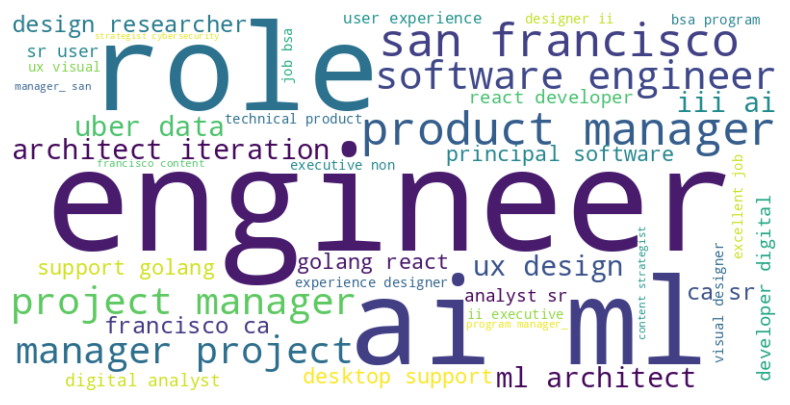

role with uber data engineer iii, ai ml architect, iteration manager ,  role product manager ai ml, ux design researcher in san francisco, ca, sr software engineer, principal software engineer, desktop support, golang react developer , digital analyst, sr user experience designer, it project manager, project manager, project engineer, technical product manager , ux visual designer ii, executive non it, excellent job bsa  program manager_ san francisco 94103 , content strategist, cybersecurity engineer 4     1    , role with uber data engineer iii, ai ml architect, iteration manager ,  role product manager ai ml, ux design researcher in san francisco, ca, sr software engineer, principal software engineer, desktop support, golang react developer , digital analyst, sr user experience designer, it project manager, project manager, project engineer, technical product manager , ux visual designer ii, executive non it, excellent job bsa  program manager_ san francisco 94103 , content strategi

In [6]:
text_data = create_wordcloud_from_job_titles(job_title_arr)
print(text_data)

In [7]:
def generate_word_frequency_pie_chart(job_title_arr: List[str]) -> None:
    """
    Generate a pie chart to visualize word frequency in the given list of job titles.

    Parameters:
        job_title_arr (List[str]): List of job titles.

    Returns:
        None.
    """
    # Concatenate all the text elements in the array into a single string
    text_data = ' '.join(job_title_arr)

    # Tokenize the text data into words
    words = word_tokenize(text_data)

    # Create a dictionary to count the occurrences of each word
    word_count_dict: Dict[str, int] = defaultdict(int)
    for word in words:
        word_count_dict[word] += 1

    # Sort the word_count_dict by frequency (largest to smallest)
    sorted_word_count: List[Tuple[str, int]] = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)

    # Extract the sorted labels and sizes from the sorted_word_count
    labels, sizes = zip(*sorted_word_count)

    # Convert the defaultdict to a regular dictionary if needed
    word_count_dict = dict(word_count_dict)

    # Generate a color gradient for the pie chart
    color_palette = sns.color_palette("Spectral", len(labels))

    # Set the figure size to be square (to make the pie chart a circle)
    plt.figure(figsize=(6, 6))

    # Plot the pie chart with the color gradient
    plt.pie(sizes, labels=labels, colors=color_palette, startangle=140)

    # Equal aspect ratio ensures that the pie chart is drawn as a circle
    plt.axis('equal')

    # Set the title for the pie chart
    plt.title('Most Frequent Words in Job Titles on Dice')

    # Show the plot
    plt.show()

## Plot Word Frequency on a Pie Chart

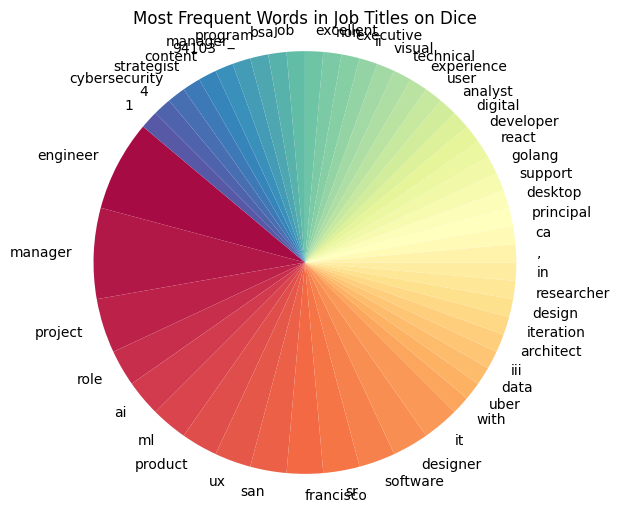

In [8]:
generate_word_frequency_pie_chart(job_title_arr)
